<a href="https://colab.research.google.com/github/antor1010/research_paper/blob/main/researchpaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy matplotlib

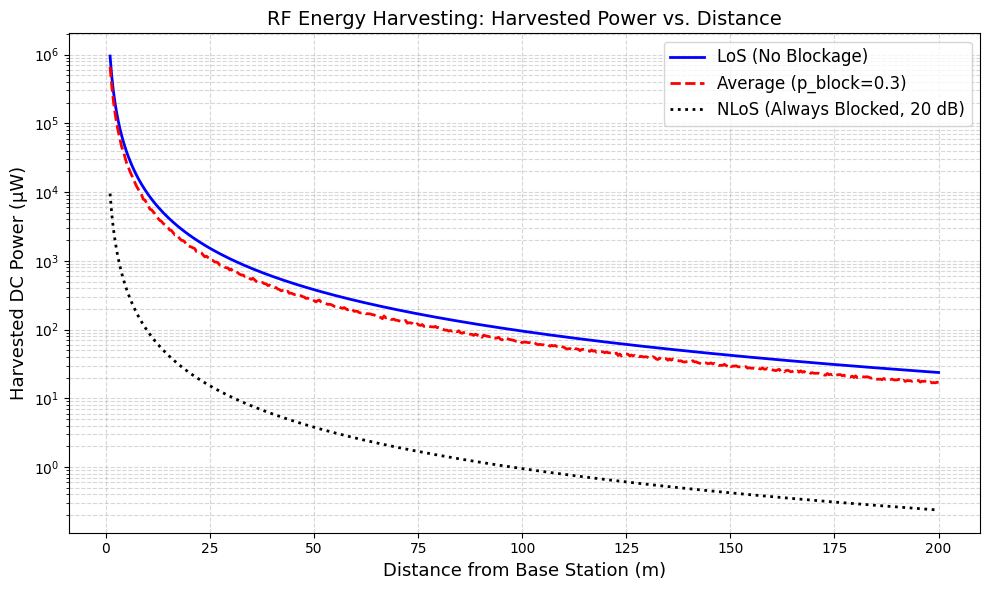

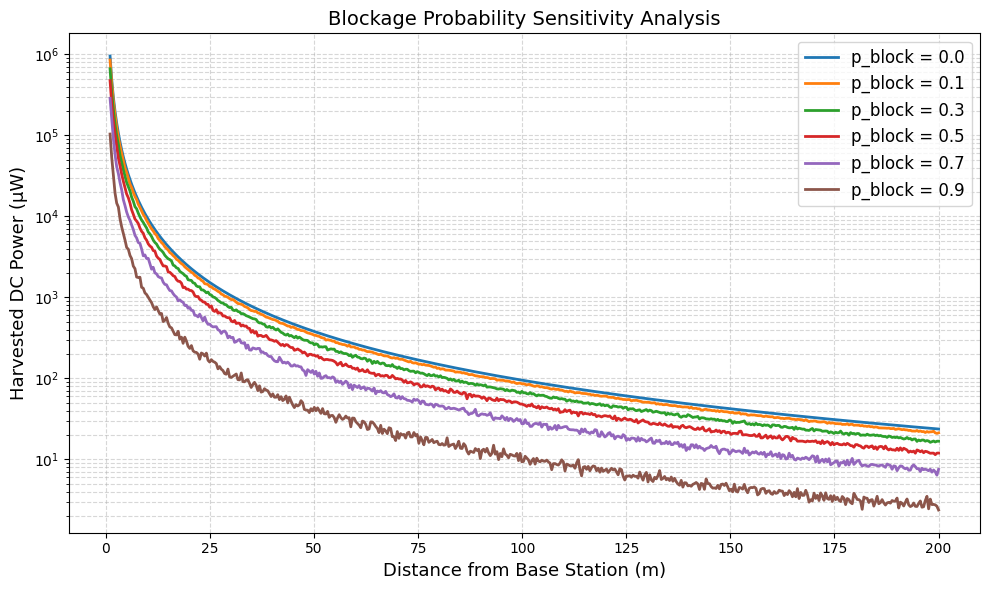

/tmp/ipython-input-3968443282.py:210: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=9)


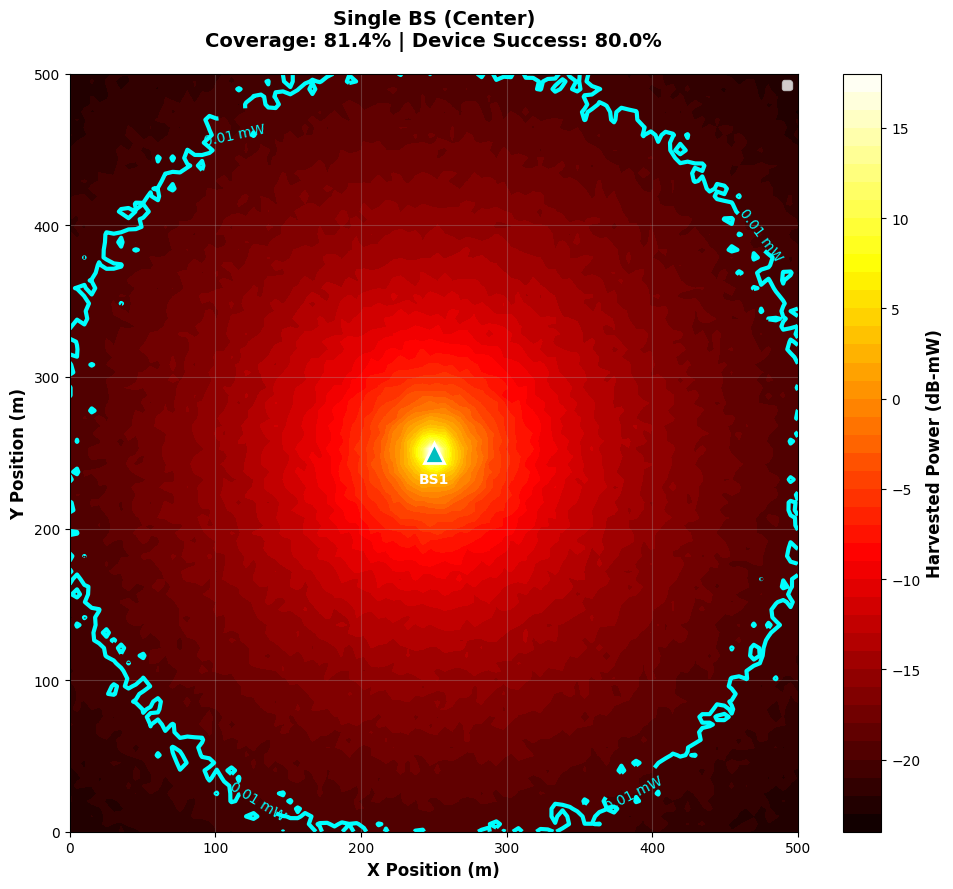

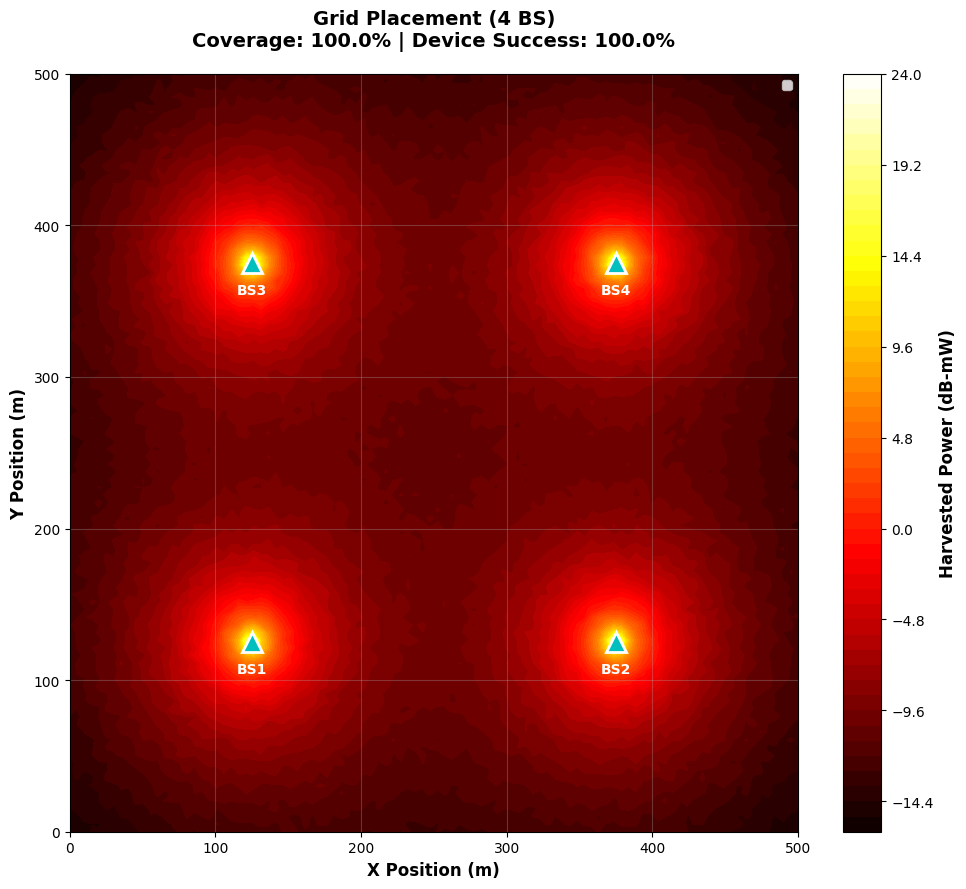

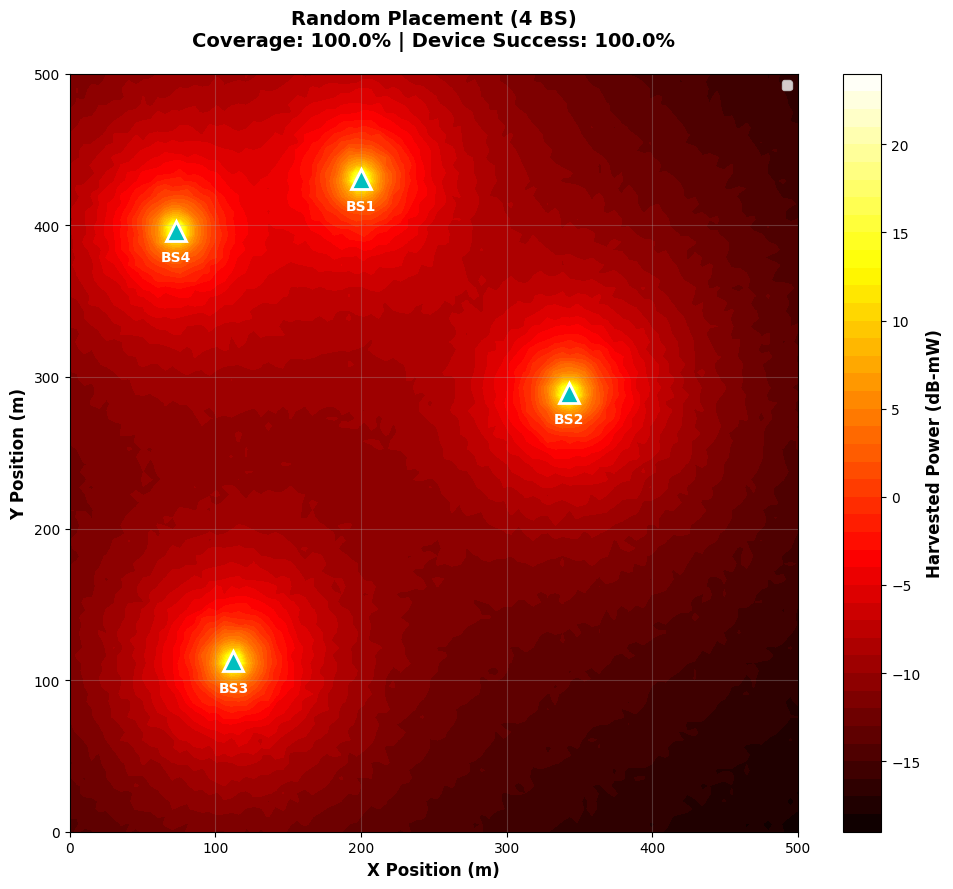

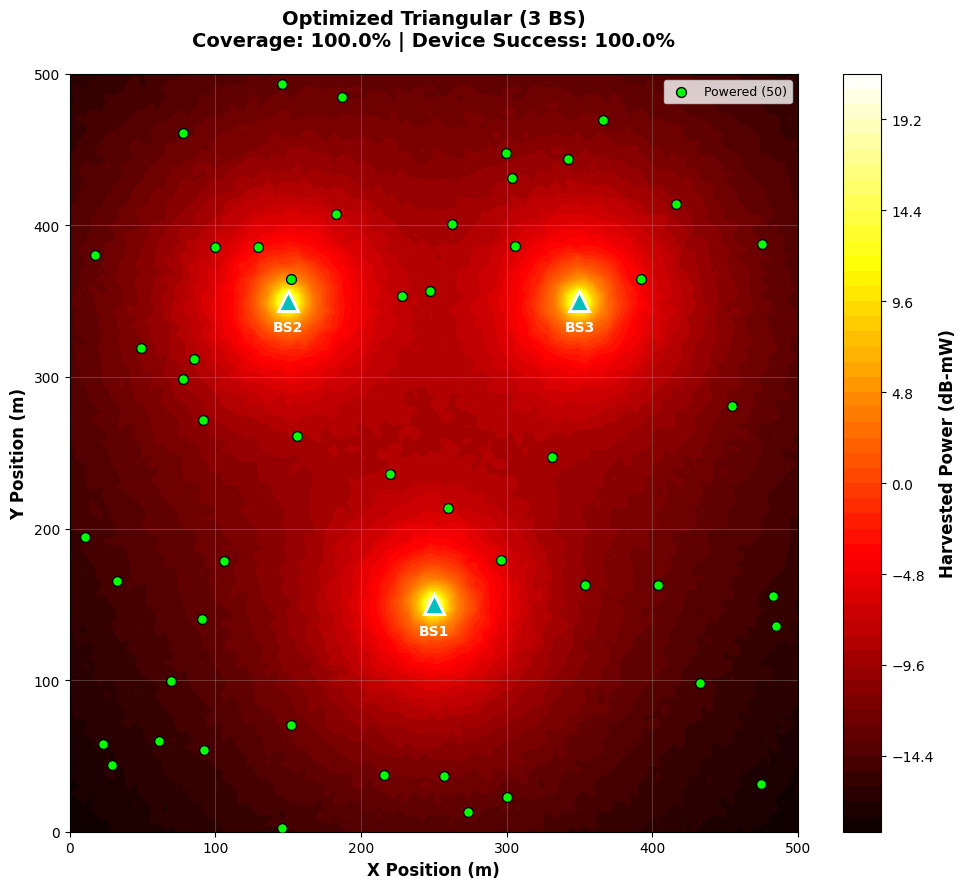

                   Scenario  Number of BS Coverage (%) Avg Power (mW) Max Power (mW) Device Success (%)
         Single BS (Center)             1        81.37         0.0843        56.0978               80.0
      Grid Placement (4 BS)             4       100.00         0.3692       227.3699              100.0
    Random Placement (4 BS)             4       100.00         0.3507       225.7676              100.0
Optimized Triangular (3 BS)             3       100.00         0.2598       141.5074              100.0


Distance (m)                    10      25      50      75      100
Scenario                                                           
Grid Placement (4 BS)        100.00  100.00  100.00  100.00  100.00
Optimized Triangular (3 BS)  100.00  100.00  100.00  100.00  100.00
Random Placement (4 BS)      100.00  100.00  100.00  100.00  100.00
Single BS (Center)           100.00  100.00  100.00  100.00  100.00


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Pt_dbm = 46
Pt = 10**(Pt_dbm / 10) / 1000
Gt_dbi = 15
Gr_dbi = 2
Gt = 10**(Gt_dbi / 10)
Gr = 10**(Gr_dbi / 10)
fc = 915e6
c = 3e8
wavelength = c / fc
eta = 0.7

blockage_loss_db = 20
blockage_prob = 0.3

distances = np.linspace(1, 200, 500)
num_trials = 1000

AREA_WIDTH = 500
AREA_HEIGHT = 500
MIN_REQUIRED_POWER_MW = 0.01

def apply_blockage(blockage_prob, blockage_loss_db, size=1):
    blocked = np.random.rand(size) < blockage_prob
    L_blockage = np.ones(size)
    L_blockage[blocked] = 10 ** (-blockage_loss_db / 10)
    return L_blockage

def received_power(Pt, Gt, Gr, wavelength, d, L_blockage):
    Pr = Pt * Gt * Gr * (wavelength / (4 * np.pi * d)) ** 2 * L_blockage
    return Pr

def harvested_power(Pr, eta):
    return eta * Pr

def simulate_harvested_power_vs_distance(distances, num_trials):
    avg_harvested = np.zeros(len(distances))
    harvested_los = np.zeros(len(distances))
    harvested_nlos = np.zeros(len(distances))

    for i, d in enumerate(distances):
        L_block = apply_blockage(blockage_prob, blockage_loss_db, size=num_trials)
        Pr = received_power(Pt, Gt, Gr, wavelength, d, L_block)
        Ph = harvested_power(Pr, eta)
        avg_harvested[i] = np.mean(Ph)

        Pr_los = received_power(Pt, Gt, Gr, wavelength, d, 1.0)
        harvested_los[i] = harvested_power(Pr_los, eta)

        L_nlos = 10 ** (-blockage_loss_db / 10)
        Pr_nlos = received_power(Pt, Gt, Gr, wavelength, d, L_nlos)
        harvested_nlos[i] = harvested_power(Pr_nlos, eta)

    return avg_harvested, harvested_los, harvested_nlos

avg_harvested, harvested_los, harvested_nlos = simulate_harvested_power_vs_distance(distances, num_trials)

plt.figure(figsize=(10, 6))
plt.semilogy(distances, harvested_los * 1e6, 'b-', linewidth=2, label='LoS (No Blockage)')
plt.semilogy(distances, avg_harvested * 1e6, 'r--', linewidth=2, label=f'Average (p_block={blockage_prob})')
plt.semilogy(distances, harvested_nlos * 1e6, 'k:', linewidth=2, label=f'NLoS (Always Blocked, {blockage_loss_db} dB)')
plt.xlabel('Distance from Base Station (m)', fontsize=13)
plt.ylabel('Harvested DC Power (μW)', fontsize=13)
plt.title('RF Energy Harvesting: Harvested Power vs. Distance', fontsize=14)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('fig1_harvested_power_vs_distance.png', dpi=300, bbox_inches='tight')
plt.show()

def blockage_sensitivity(distances, blockage_probs, blockage_loss_db, num_trials=1000):
    plt.figure(figsize=(10, 6))

    for bp in blockage_probs:
        avg_harvested = np.zeros(len(distances))
        for i, d in enumerate(distances):
            L_block = apply_blockage(bp, blockage_loss_db, size=num_trials)
            Pr = received_power(Pt, Gt, Gr, wavelength, d, L_block)
            avg_harvested[i] = np.mean(harvested_power(Pr, eta))

        plt.semilogy(distances, avg_harvested * 1e6, linewidth=2, label=f'p_block = {bp:.1f}')

    plt.xlabel('Distance from Base Station (m)', fontsize=13)
    plt.ylabel('Harvested DC Power (μW)', fontsize=13)
    plt.title('Blockage Probability Sensitivity Analysis', fontsize=14)
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('fig2_blockage_sensitivity.png', dpi=300, bbox_inches='tight')
    plt.show()

blockage_probs = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
blockage_sensitivity(distances, blockage_probs, blockage_loss_db)

def calculate_total_power_at_point(x, y, base_stations, num_trials=100):
    total_power = 0

    for bs in base_stations:
        bs_x, bs_y = bs['position']
        distance = np.sqrt((x - bs_x)**2 + (y - bs_y)**2)

        if distance < 0.1:
            distance = 0.1

        L_block = apply_blockage(blockage_prob, blockage_loss_db, size=num_trials)
        Pr = received_power(Pt, Gt, Gr, wavelength, distance, L_block)
        Ph = harvested_power(Pr, eta)
        total_power += np.mean(Ph)

    return total_power * 1000

def generate_heatmap(base_stations, resolution=100):
    x = np.linspace(0, AREA_WIDTH, resolution)
    y = np.linspace(0, AREA_HEIGHT, resolution)
    X, Y = np.meshgrid(x, y)

    Z = np.zeros_like(X)

    for i in range(resolution):
        for j in range(resolution):
            Z[i, j] = calculate_total_power_at_point(X[i, j], Y[i, j], base_stations)

    return X, Y, Z

def analyze_coverage(base_stations, X, Y, Z):
    total_points = X.size
    covered_points = np.sum(Z >= MIN_REQUIRED_POWER_MW)
    coverage_percentage = (covered_points / total_points) * 100

    avg_power = np.mean(Z)
    max_power = np.max(Z)
    min_power = np.min(Z)

    return {
        'coverage_percentage': coverage_percentage,
        'avg_power_mw': avg_power,
        'max_power_mw': max_power,
        'min_power_mw': min_power,
        'covered_points': covered_points,
        'total_points': total_points
    }

def test_random_devices(base_stations, num_devices=50):
    np.random.seed(42)
    device_x = np.random.uniform(0, AREA_WIDTH, num_devices)
    device_y = np.random.uniform(0, AREA_HEIGHT, num_devices)

    powered_devices = 0
    device_powers = []

    for x, y in zip(device_x, device_y):
        power = calculate_total_power_at_point(x, y, base_stations)
        device_powers.append(power)

        if power >= MIN_REQUIRED_POWER_MW:
            powered_devices += 1

    success_rate = (powered_devices / num_devices) * 100

    return device_x, device_y, device_powers, success_rate

def plot_heatmap_with_devices(base_stations, X, Y, Z, title, filename, show_devices=True):
    fig, ax = plt.subplots(figsize=(10, 9))

    Z_db = 10 * np.log10(Z + 1e-12)
    im = ax.contourf(X, Y, Z_db, levels=50, cmap='hot')

    for bs in base_stations:
        x, y = bs['position']
        ax.plot(x, y, 'c^', markersize=15, markeredgecolor='white',
                markeredgewidth=2)
        ax.text(x, y-20, bs['name'], ha='center',
                fontsize=10, fontweight='bold', color='white')

    if show_devices:
        dev_x, dev_y, dev_powers, success_rate = test_random_devices(base_stations, 50)

        powered_idx = [i for i, p in enumerate(dev_powers) if p >= MIN_REQUIRED_POWER_MW]
        unpowered_idx = [i for i, p in enumerate(dev_powers) if p < MIN_REQUIRED_POWER_MW]

        if powered_idx:
            ax.scatter([dev_x[i] for i in powered_idx],
                      [dev_y[i] for i in powered_idx],
                      c='lime', s=50, marker='o', edgecolors='black',
                      linewidth=1, label=f'Powered ({len(powered_idx)})',
                      zorder=5)

        if unpowered_idx:
            ax.scatter([dev_x[i] for i in unpowered_idx],
                      [dev_y[i] for i in unpowered_idx],
                      c='red', s=50, marker='x', linewidth=2,
                      label=f'Unpowered ({len(unpowered_idx)})',
                      zorder=5)

    contour_line = ax.contour(X, Y, Z, levels=[MIN_REQUIRED_POWER_MW],
                              colors='cyan', linewidths=3)
    ax.clabel(contour_line, inline=True, fontsize=10,
              fmt=f'{MIN_REQUIRED_POWER_MW} mW')

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Harvested Power (dB-mW)', fontsize=12, fontweight='bold')

    ax.set_xlabel('X Position (m)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Y Position (m)', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=9)

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

def scenario_single_bs():
    return [{'position': (250, 250), 'name': 'BS1'}]

def scenario_grid_bs():
    return [
        {'position': (125, 125), 'name': 'BS1'},
        {'position': (375, 125), 'name': 'BS2'},
        {'position': (125, 375), 'name': 'BS3'},
        {'position': (375, 375), 'name': 'BS4'},
    ]

def scenario_random_bs(num_bs=4, seed=42):
    np.random.seed(seed)
    bs_positions = np.random.uniform(50, AREA_WIDTH - 50, size=(num_bs, 2))
    return [{'position': tuple(pos), 'name': f'BS{i+1}'} for i, pos in enumerate(bs_positions)]

def scenario_optimized_bs():
    return [
        {'position': (250, 150), 'name': 'BS1'},
        {'position': (150, 350), 'name': 'BS2'},
        {'position': (350, 350), 'name': 'BS3'},
    ]

scenarios = [
    ("Single BS (Center)", scenario_single_bs()),
    ("Grid Placement (4 BS)", scenario_grid_bs()),
    ("Random Placement (4 BS)", scenario_random_bs()),
    ("Optimized Triangular (3 BS)", scenario_optimized_bs()),
]

results = []

for idx, (scenario_name, base_stations) in enumerate(scenarios):
    X, Y, Z = generate_heatmap(base_stations, resolution=100)
    stats = analyze_coverage(base_stations, X, Y, Z)
    _, _, _, success_rate = test_random_devices(base_stations, num_devices=50)

    results.append({
        'Scenario': scenario_name,
        'Number of BS': len(base_stations),
        'Coverage (%)': f"{stats['coverage_percentage']:.2f}",
        'Avg Power (mW)': f"{stats['avg_power_mw']:.4f}",
        'Max Power (mW)': f"{stats['max_power_mw']:.4f}",
        'Device Success (%)': f"{success_rate:.1f}",
    })

    show_dev = (idx == len(scenarios) - 1)
    filename = f"fig{idx+3}_heatmap_{scenario_name.replace(' ', '_').replace('(', '').replace(')', '').lower()}.png"
    plot_heatmap_with_devices(base_stations, X, Y, Z,
                             f"{scenario_name}\nCoverage: {stats['coverage_percentage']:.1f}% | Device Success: {success_rate:.1f}%",
                             filename, show_devices=show_dev)

df = pd.DataFrame(results)
print(df.to_string(index=False))

df.to_csv('table1_comparison.csv', index=False)

latex_table = df.to_latex(index=False, caption='Performance comparison of base station placement strategies',
                           label='tab:comparison', column_format='lcccccc')
with open('table1_comparison.tex', 'w') as f:
    f.write(latex_table)

stats_summary = []
for scenario_name, base_stations in scenarios:
    X, Y, Z = generate_heatmap(base_stations, resolution=100)

    for d in [10, 25, 50, 75, 100]:
        count = 0
        total = 0
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                for bs in base_stations:
                    bs_x, bs_y = bs['position']
                    dist = np.sqrt((X[i,j] - bs_x)**2 + (Y[i,j] - bs_y)**2)
                    if dist <= d:
                        total += 1
                        if Z[i,j] >= MIN_REQUIRED_POWER_MW:
                            count += 1
                        break

        coverage = (count / total * 100) if total > 0 else 0
        stats_summary.append({
            'Scenario': scenario_name,
            'Distance (m)': d,
            'Coverage (%)': f"{coverage:.2f}"
        })

df_distance = pd.DataFrame(stats_summary)
df_distance_pivot = df_distance.pivot(index='Scenario', columns='Distance (m)', values='Coverage (%)')

print("\n")
print(df_distance_pivot.to_string())

df_distance_pivot.to_csv('table2_distance_coverage.csv')

latex_table2 = df_distance_pivot.to_latex(caption='Coverage percentage at various distances from base stations',
                                          label='tab:distance_coverage')
with open('table2_distance_coverage.tex', 'w') as f:
    f.write(latex_table2)